In [691]:
import json
import os
import numpy
import pandas
import pyarrow
import sys

from datetime import date
from os import path
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Steps to install
# 1. pip install sqlalchemy-bigquery google-cloud-bigquery-storage pyarrow
# 2. Copy the credentials file to wherever you set BIGQUERY_CREDENTIALS_PATH to

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')

In [692]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from bespoke.inventory.analysis.shared import create_queries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [755]:
COMPANY_NAME = 'BBF'
COMPANY_IDENTIFIER = 'BBF'
TRANSFER_PACKAGES_START_DATE = '2019-01-01'
SALES_TRANSACTIONS_START_DATE = '2019-01-01'
INVENTORY_DATES = [
    '09/30/2020',
    '10/31/2020',
    '11/30/2020',
    '12/31/2020',
    '01/31/2021',
    '02/28/2021',
    '03/31/2021',
    '04/30/2021',
    '05/31/2021',
    '06/30/2021',
    '07/31/2021',
    '08/31/2021',
    '09/30/2021',
]

# NOTE: I overwrote the Shake/Trim numbers because
# they didn't seem right, and used the Shake / Trim (by strain)
# numbers.
company_pricing_table = {
    'Buds': {'Grams': 3.21, 'Pounds': 1750.48}, 
    'Concentrate': {'Grams': 32.92, 'Pounds': 14931.64}, 
    'Concentrate (Each)': {'Each': 9.41}, 
    'Infused (edible)': {'Each': 5.38}, 
    'Infused (non-edible)': {'Each': 36.37}, 
    'Infused Beverage': {'Each': 2.5}, 
    'Raw Pre-Rolls': {'Grams': 5.86, 'Pounds': 2657.77}, 
    'Shake/Trim': {'Grams': 0.4, 'Pounds': 182.19}, 
    'Shake/Trim (by strain)': {'Grams': 0.4, 'Pounds': 182.19}, 
    'Vape Product': {'Each': 11.24}, 
    'Concentrate (Bulk)': {'Grams': 32.92, 'Pounds': 14931.64}
}
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
    'use_prices_to_fill_missing_incoming': True,
    'external_pricing_data_config': {
        'category_to_fixed_prices': company_pricing_table
    }
}
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES.append(TODAY_DATE)
print('Today is {}'.format(TODAY_DATE))

Today is 11/09/2021


In [643]:
# Download packages, sales transactions, incoming / outgoing tranfers

company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER, include_quantity_zero=True)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))
company_incoming_transfer_packages_dataframe = pandas.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pandas.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_sales_transactions_dataframe = pandas.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)
company_inventory_packages_dataframe = pandas.read_sql_query(company_inventory_packages_query, engine)

In [644]:
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
unknown_transfers_df = pandas.read_sql_query(company_unknown_transfer_packages_query, engine)
len(unknown_transfers_df)


0

In [756]:
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
import importlib

importlib.reload(util)
importlib.reload(valuations_util)

<module 'bespoke.inventory.analysis.inventory_valuations_util' from '/Users/davidlluncor/GitHub/platform/services/api-server/src/bespoke/inventory/analysis/inventory_valuations_util.py'>

In [757]:
d = util.Download()
sql_helper = util.BigQuerySQLHelper(engine)
d.download_dataframes(
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
    sales_transactions_dataframe=company_sales_transactions_dataframe,
    sales_receipts_dataframe=company_sales_receipts_dataframe,
    inventory_packages_dataframe=company_inventory_packages_dataframe,
    sql_helper=sql_helper
)

In [502]:
d.child_to_parent_package_id_override = {
}

In [758]:
importlib.reload(util)
importlib.reload(valuations_util)

# Check for how many packages are excluded from analysis,
# seeing less then 2% is really good
q = util.Query()
q.inventory_dates = INVENTORY_DATES
q.company_name = COMPANY_NAME

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(id_to_history)
util.create_inventory_xlsx(id_to_history, q, params=ANALYSIS_PARAMS, 
                           show_debug_package_ids=False)

Only outgoing: 43
Only incoming: 184
Sold packages missing pricing information: 0 (0.00% of packages)
In and out: 25
In and sold at least once 746
In and sold many times 723

 Num parent packages: 0
 num matched child packages: 239
Total pkgs: 986
Wrote result to out/BBF_inventory_by_month.xls
Excluded 43 / 986 packages from consideration (4.36%)
  MISSING_INCOMING: 43 times


In [740]:
# For debugging individual package histories
# You have to run the above block to reload the package_id_to_history array

import importlib
importlib.reload(util)
importlib.reload(valuations_util)

# Missing transactions?
# 5189649

# Using grams or missing transactions?
#WARN: seeing an incoming package for #19083030 with no received_datetime
#Exception: FATAL error, could not find a transfer to insert a tx with date
#2021-10-22 11:58:45+00:00 into for package 18218608

# '2818807' - child

PACKAGE_IDS = [
  '1001679', '2818227'
]

util.analyze_specific_package_histories(
    d, package_id_to_actual_row, PACKAGE_IDS, params=ANALYSIS_PARAMS)

DEBUGGING PACKAGE_ID=1001679
! Missing in metrc_packages
Excluding package 1001679 because it doesnt have an incoming package
CHILD TO PARENT MATCHING ANALYSIS

DEBUGGING PACKAGE_ID=2818227
! Missing in metrc_packages
Excluding package 2818227 because it doesnt have an incoming package
CHILD TO PARENT MATCHING ANALYSIS



In [650]:
util.run_orphan_analysis(d, id_to_history)

11 - Number of parent packages

207 - Child packages with parents
32 - orphans; child packages with (no source product batch num)
0 - no matching parent; child packages that have a source batch number, but no parent


In [759]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

#INVENTORY_DATES = [TODAY_DATE]

date_to_inventory_packages_dataframe = {}

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names()
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    inventory_valuations.append(valuations_util.get_total_valuation_for_date(
        computed_inventory_packages_dataframe=computed_inventory_packages_dataframe,
        company_incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe
    ))

# packages in inventory: 73
# packages in inventory: 80
# packages in inventory: 89
# packages in inventory: 74
# packages in inventory: 107
# packages in inventory: 127
# packages in inventory: 138
# packages in inventory: 159
# packages in inventory: 177
# packages in inventory: 209
# packages in inventory: 189
# packages in inventory: 233
# packages in inventory: 245
# packages in inventory: 252


In [760]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

# Do the COGS summary too
topdown_cogs_rows = util.create_top_down_cogs_summary_for_all_dates(
    d, ANALYSIS_PARAMS
)

bottomsup_cogs_rows = util.create_cogs_summary_for_all_dates(
  id_to_history, ANALYSIS_PARAMS
)
util.write_cogs_xlsx(
    topdown_cogs_rows=topdown_cogs_rows, 
    bottoms_up_cogs_rows=bottomsup_cogs_rows,
    company_name=COMPANY_NAME
)

Wrote result to out/BBF_cogs_summary.xls


In [761]:
from_packages_inventory_dataframe = company_inventory_packages_dataframe[[
    'package_id',
    'packaged_date',
    'unit_of_measure',
    'product_category_name',
    'product_name',
    'quantity',
]].sort_values('package_id')

package_id_to_actual_row = {}
for index, row in from_packages_inventory_dataframe.iterrows():
    package_id_to_actual_row[str(row['package_id'])] = row

In [762]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

res = util.compare_inventory_dataframes(
    computed=date_to_inventory_packages_dataframe[TODAY_DATE],
    actual=from_packages_inventory_dataframe,
    options={
        'num_errors_to_show': 100,
        'accept_computed_when_sold_out': True
    }
)

# Two categories for: Num actual packages not computed: 229
# 1. Actual has a package that we've never seen
# 2. Actual has a package that we've sold out of, and that's why it's in the inventory

# Two categories for: Num computed packages not in actual: 237
# 1. We never saw the package in the actual inventory
# 2. Actual inventory is sold out, but we think it's not sold out in computed

Pct of # inventory matching: 100.00% (252 / 252)
Accuracy of quantities: 95.17%
Pct of # inventory packages over-estimated: 0.00%
Pct of # quantity over-estimated: 0.00%
Avg quantity delta: 7.04
Avg quantity: 145.61

Num matching packages: 252
Num actual packages not computed: 0
  but computed at some point: 0, e.g., 0.00% of non-computed packages
  avg quantity from actual packages 0.00
Num computed packages not in actual: 0
  but in actual inventory at some point: 0

Computed has these extra package IDs; first 100

Computed is missing these package IDs; first 100


In [636]:
res

{'computed_extra_package_ids': set(),
 'computed_missing_actual_package_ids': ['2818807',
  '2229543',
  '2818701',
  '2817078',
  '2250543',
  '2229684',
  '2083306',
  '2885707',
  '1279890',
  '2816849',
  '2059498',
  '1279888',
  '1280225',
  '1970101',
  '1279887']}

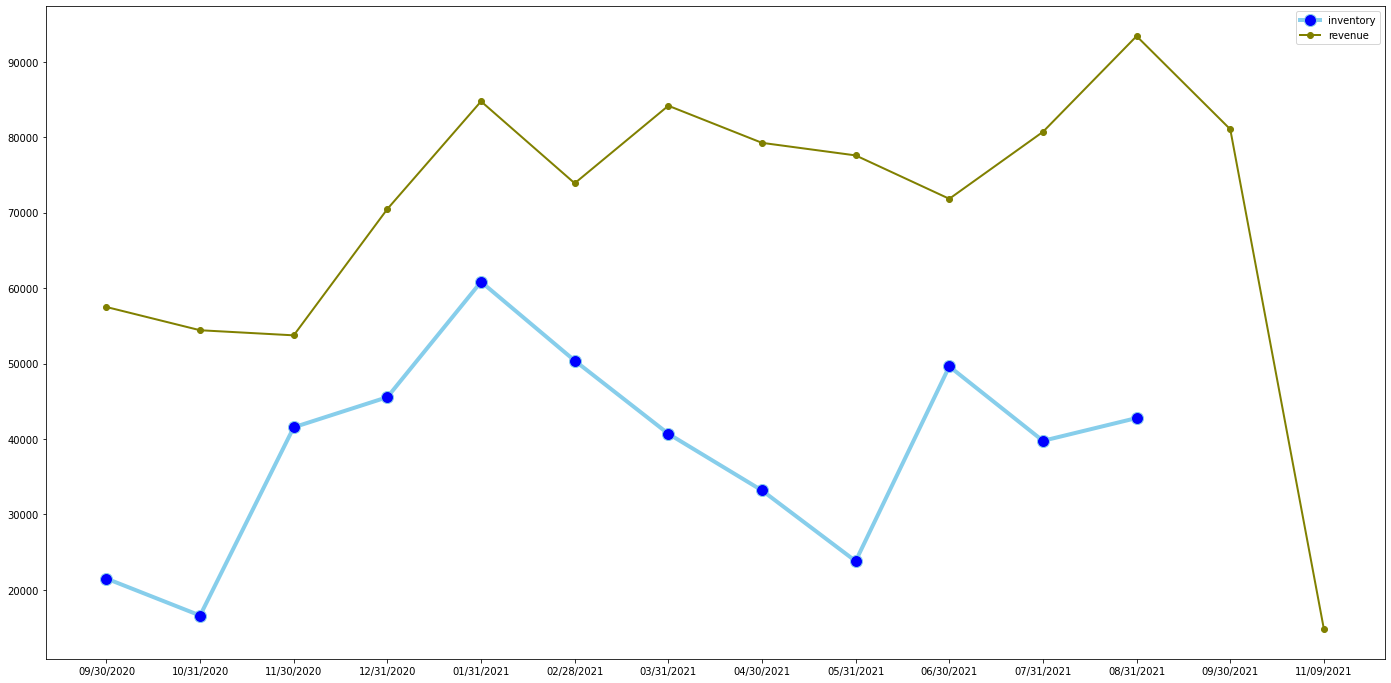

In [763]:
import importlib
importlib.reload(util)
importlib.reload(valuations_util)

valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=inventory_valuations
)

In [270]:
inactive_packages_df = pandas.read_sql_query(
    util.are_packages_inactive_query(['766095']),
    engine
)
inactive_packages_df

,identifier,license_number,type,package_id,package_label,product_category_name,product_name,archiveddate,finisheddate,quantity
0,HPCC,C10-0000064-LIC,inactive,766095,1A406030000339D000000028,Leaf,wedding crasher trim,None,2020-02-22,0.0


In [531]:
# Find transfer packages in data warehouse by package_id.

def create_transfer_packages_by_package_id_query(package_id):
    return f"""
        select
            companies.identifier,
            company_deliveries.delivery_type,
            company_deliveries.updated_at,
            metrc_transfer_packages.package_id,
            metrc_transfer_packages.package_label,
            metrc_transfer_packages.shipped_quantity,
            metrc_transfer_packages.shipper_wholesale_price,
            metrc_transfers.shipper_facility_name,
            metrc_transfers.shipper_facility_license_number,
            metrc_deliveries.recipient_facility_name,
            metrc_deliveries.recipient_facility_license_number,
            metrc_transfer_packages.package_payload.*
        from
            metrc_transfer_packages
            inner join metrc_deliveries on metrc_transfer_packages.delivery_row_id = metrc_deliveries.id
            inner join metrc_transfers on metrc_deliveries.transfer_row_id = metrc_transfers.id
            inner join company_deliveries on metrc_transfers.id = company_deliveries.transfer_row_id
            inner join companies on company_deliveries.company_id = companies.id
        where
            True
            and metrc_transfer_packages.package_id = '{package_id}'
    """

transfer_packages_by_package_id_query = create_transfer_packages_by_package_id_query(
    2213735)
transfer_packages_by_package_id_dataframe = pandas.read_sql_query(transfer_packages_by_package_id_query, engine)
transfer_packages_by_package_id_dataframe

,identifier,delivery_type,updated_at,package_id,package_label,shipped_quantity,shipper_wholesale_price,shipper_facility_name,shipper_facility_license_number,recipient_facility_name,...,itemunitvolume,itemunitvolumeunitofmeasurename,shipperwholesaleprice,receiverwholesaleprice,remediationdate,itemunitthccontent,itemunitthccontentunitofmeasurename,grossunitofweightname,itemunitcbdcontent,itemunitcbdcontentunitofmeasurename
0,BBF,INCOMING_UNKNOWN,2021-10-28 23:47:40.803000+00:00,2213735,1A40A0300004845000000300,1.395,0.01,"Pure Industries, Inc.",MC281411,Boston Bud Factory Inc.,...,None,None,0.01,0.01,None,None,None,None,None,None


In [535]:
transfer_packages_by_package_id_dataframe['receiverwholesaleprice']

0    0.01
Name: receiverwholesaleprice, dtype: float64

In [534]:
transfer_packages_by_package_id_dataframe.iloc[0].array

<PandasArray>
[                                                 'BBF',
                                     'INCOMING_UNKNOWN',
 Timestamp('2021-10-28 23:47:40.803000+0000', tz='UTC'),
                                              '2213735',
                             '1A40A0300004845000000300',
                                                  1.395,
                                                   0.01,
                                'Pure Industries, Inc.',
                                             'MC281411',
                              'Boston Bud Factory Inc.',
                                             'MR281525',
                                                2213735,
                             '1A40A0300004845000000300',
                                              'Product',
                              "5/17/21- Pinky's Advice",
   '1A40A0300004845000000080, 1A40A0300004845000000135',
                    "M00000757406: Pinky's Advice Buds",
                 

In [525]:
transfer_packages_by_package_id_dataframe.columns

Index(['identifier', 'delivery_type', 'updated_at', 'package_id',
       'package_label', 'shipped_quantity', 'shipper_wholesale_price',
       'shipper_facility_name', 'shipper_facility_license_number',
       'recipient_facility_name', 'recipient_facility_license_number',
       'packageid', 'packagelabel', 'packagetype', 'sourceharvestnames',
       'sourcepackagelabels', 'productname', 'productcategoryname',
       'itemstrainname', 'itemunitweight', 'itemunitweightunitofmeasurename',
       'itemservingsize', 'labtestingstate', 'istradesample',
       'istradesamplepersistent', 'sourcepackageistradesample', 'isdonation',
       'sourcepackageisdonation', 'istestingsample',
       'productrequiresremediation', 'containsremediatedproduct',
       'shipmentpackagestate', 'shippedquantity', 'shippedunitofmeasurename',
       'receivedquantity', 'receivedunitofmeasurename', 'deliveryid',
       'itemunitvolume', 'itemunitvolumeunitofmeasurename',
       'shipperwholesaleprice', 'receiv

In [490]:
# Find packages in data warehouse by package_id.

def create_packages_by_package_id_query(package_id):
    return f"""
        select
            companies.identifier,
            metrc_packages.package_id,
            metrc_packages.package_label,
            metrc_packages.quantity,
            metrc_packages.package_payload.*
        from
            metrc_packages
            inner join companies on metrc_packages.company_id = companies.id
        where
            True
            and metrc_packages.package_id = '{package_id}'
    """

packages_by_package_id_query = create_packages_by_package_id_query(17481729)
packages_by_package_id_dataframe = pandas.read_sql_query(packages_by_package_id_query, engine)
packages_by_package_id_dataframe

,identifier,package_id,package_label,quantity,id,label,packagetype,sourceharvestnames,quantity_1,unitofmeasurename,...,locationname,locationtypename,itemunitvolume,itemunitvolumeunitofmeasurename,archiveddate,itemunitthccontent,itemunitthccontentunitofmeasurename,remediationdate,itemunitcbdcontent,itemunitcbdcontentunitofmeasurename
0,RA,17481729,1A4060300003BC9000058384,1.0,17481729,1A4060300003BC9000058384,Product,"A062221R08GEL, S062821R06GEL",0.0,Each,...,None,None,None,None,None,None,None,None,None,None


In [491]:
packages_by_package_id_dataframe.columns

Index(['identifier', 'package_id', 'package_label', 'quantity', 'id', 'label',
       'packagetype', 'sourceharvestnames', 'quantity_1', 'unitofmeasurename',
       'unitofmeasureabbreviation', 'patientlicensenumber',
       'itemfromfacilitylicensenumber', 'itemfromfacilityname', 'note',
       'packageddate', 'initiallabtestingstate', 'labtestingstate',
       'labtestingstatedate', 'isproductionbatch', 'productionbatchnumber',
       'sourceproductionbatchnumbers', 'istradesample',
       'istradesamplepersistent', 'sourcepackageistradesample', 'isdonation',
       'isdonationpersistent', 'sourcepackageisdonation', 'istestingsample',
       'isprocessvalidationtestingsample', 'productrequiresremediation',
       'containsremediatedproduct', 'isonhold', 'lastmodified', 'itemid',
       'itemname', 'itemproductcategoryname', 'itemproductcategorytype',
       'itemquantitytype', 'itemdefaultlabtestingstate',
       'itemunitofmeasurename', 'itemapprovalstatus',
       'itemapprovalstat

In [392]:
from bespoke.metrc.common import metrc_common_util

rest = metrc_common_util.get_rest_helper_for_debug(
    us_state='MA',
    license_number='MR281525'
)

In [360]:
from dateutil import parser
from datetime import timedelta

start_date = parser.parse('2020/01/01').date()
end_date = parser.parse('2020/01/01').date()

cur_date = start_date

while cur_date <= end_date:
    cur_date_str = cur_date.strftime('%m/%d/%Y')
    resp = rest.get('/transfers/v1/rejected', time_range=[cur_date_str])
    transfers = json.loads(resp.content)
    if len(transfers) > 0:
        print('FOUND SOME')
        break
        
    cur_date = cur_date + timedelta(days=1)
    

https://api-ca.metrc.com/transfers/v1/rejected?licenseNumber=C10-0000596-LIC&lastModifiedStart=2020-01-01T00:00:00


In [394]:
resp = rest.get('/packages/v1/967657')

https://api-ma.metrc.com/packages/v1/967657?licenseNumber=MR281525


In [391]:
os.environ['JUPYTER_NOTEBOOK_METRC_API_KEY'] = ''

In [390]:
os.environ['METRC_VENDOR_KEY_MA'] = ''

In [750]:
pricing_table = {'Buds': {'Grams': 3.207749486491558, 'Pounds': 1750.4774029280713},
 'Concentrate': {'Grams': 32.91866028708134, 'Pounds': 14931.640956937797},
 'Concentrate (Each)': {'Each': 9.407892857142858},
 'Infused (edible)': {'Each': 5.380780767534184},
 'Infused (non-edible)': {'Each': 36.36986301369863},
 'Infused Beverage': {'Each': 2.5},
 'Raw Pre-Rolls': {'Grams': 5.859388272870396, 'Pounds': 2657.7716454678284},
 'Shake/Trim': {'Grams': 0.0013664149586479683, 'Pounds': 0.6197948939230492},
 'Shake/Trim (by strain)': {'Grams': 0.40165429042904294,
  'Pounds': 182.18717290429043},
 'Vape Product': {'Each': 11.236736401673639},
 'Concentrate (Bulk)': {'Grams': 32.91866028708134,
  'Pounds': 14931.640956937797}}

In [754]:
def _round_pricing_table(pricing_table):
    toplevel_keys = list(pricing_table.keys())
    for k in toplevel_keys:
        v = pricing_table[k]
        sub_keys = list(v.keys())
        for subkey in sub_keys:
            v[subkey] = round(v[subkey], 2)
            
    return pricing_table
    
print(_round_pricing_table(pricing_table))

{'Buds': {'Grams': 3.21, 'Pounds': 1750.48}, 'Concentrate': {'Grams': 32.92, 'Pounds': 14931.64}, 'Concentrate (Each)': {'Each': 9.41}, 'Infused (edible)': {'Each': 5.38}, 'Infused (non-edible)': {'Each': 36.37}, 'Infused Beverage': {'Each': 2.5}, 'Raw Pre-Rolls': {'Grams': 5.86, 'Pounds': 2657.77}, 'Shake/Trim': {'Grams': 0.0, 'Pounds': 0.62}, 'Shake/Trim (by strain)': {'Grams': 0.4, 'Pounds': 182.19}, 'Vape Product': {'Each': 11.24}, 'Concentrate (Bulk)': {'Grams': 32.92, 'Pounds': 14931.64}}
